# Benchmarking

> Comparing the DRSA model to some other baseline models.

* *Note*: with the drsa, we can use embeddings. With the other models we cannot.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F

# from drsa.functions import event_time_loss, event_rate_loss
from drsa.model import DRSA

from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
embedding_cols = ["pitcher"] # ["game_pk",  "game_type", "pitcher_team_year"]
feature_cols = ["post_bat_score", "score_diff", "end_inning", "inning", "postouts", "cum_sb_ratio",
                "times_thru_order", "post_total_runners", "tying_run_on", "pitch_total", "post_opposite_hand",
                "walk", 'walk_cumsum', 'strikeout_cumsum', 'home_run_cumsum', 'bases_cumsum']
cols = embedding_cols + feature_cols

In [3]:
train = pd.read_csv("../data/processed/train_2016_2017_2018.csv")
val = pd.read_csv("../data/processed/val_2016_2017_2018.csv")
test = pd.read_csv("../data/processed/test_2019.csv")

with open("../data/processed/mappers_2016_2017_2018_2019.pkl", "rb") as f:
    mappers = pickle.load(f)
    
with open("../data/processed/scaler_2016_2017_2018_2019.pkl", "rb") as f:
    scaler = pickle.load(f)
    
# scaling test data (as tuned on training data)
test[feature_cols] = scaler.transform(test[feature_cols])

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
X_train, X_test, y_train, y_test = train[feature_cols], test[feature_cols], train["pulled"], test["pulled"] 

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     45155
         1.0       0.67      0.21      0.32      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.60      0.65     47189
weighted avg       0.95      0.96      0.95     47189

mean plate appearance diff: 0.22026
mean target diff: 0.02861


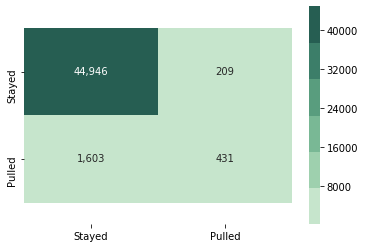

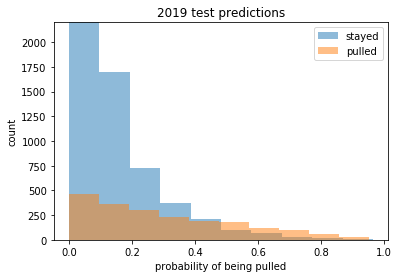

In [7]:
print_all_metrics(y_test, log_reg.predict_proba(X_test)[:, 1], thresh=0.5)

## Gradient-Boosted Tree

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
gbt = GradientBoostingClassifier(subsample=0.5)
gbt.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     45155
         1.0       0.68      0.26      0.37      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.63      0.68     47189
weighted avg       0.95      0.96      0.95     47189

mean plate appearance diff: 0.21534
mean target diff: 0.0287


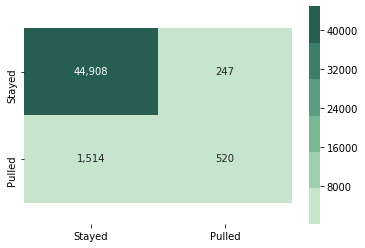

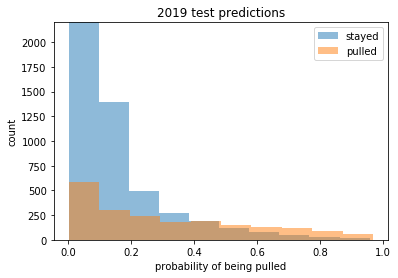

In [10]:
print_all_metrics(y_test, gbt.predict_proba(X_test)[:, 1], thresh=0.5)

## DRSA

In [11]:
def get_starts(df, cols, y_col="last_batter"):
    """
    Given a dataframe with many pitcher outings stacked on top of one another,
    this function extracts each individual outing
    """
    start_stats = np.array(df[cols])
    removal = np.array(df[y_col])
    pulled_idx = np.nonzero(removal)[0]
    stats = []
    for i in range(pulled_idx.shape[0]):
        if i == 0:
            stat = start_stats[: pulled_idx[i] + 1]
        else:
            stat = start_stats[pulled_idx[i - 1] + 1: pulled_idx[i] + 1]

        stats.append(stat)
    return stats
    
def front_pad(starts):
    """
    starts is a list of np arrays. Each has a shape of
    (# batters faced, # features)
    """
    n_features = starts[0].shape[1]
    longest = np.max([start.shape[0] for start in starts])
    padded_starts = []
    for start in starts:
        length = start.shape[0]
        difference = longest - length
        pad = np.zeros((difference, n_features)) # this also just puts a zero in for the target
        padded_start = np.vstack([pad, start])
        padded_starts.append(padded_start)
    return padded_starts

In [12]:
# quick dropping of a few unneeded columns
train = train.drop(columns=['game_type', 'pitcher_team_year'])
test = test.drop(columns=['game_type', 'pitcher_team_year'])

In [13]:
# getting each individual start
train_starts = get_starts(train, cols=cols, y_col="pulled")
test_starts = get_starts(test, cols=cols, y_col="pulled")

# adding targets back
train_starts = add_targets(train_starts)
test_starts = add_targets(test_starts)

# front-padding for parallelized training
padded_train_starts = front_pad(train_starts)
padded_test_starts = front_pad(test_starts)

In [14]:
class PTPDataset(Dataset):
    def __init__(self, starts):
        """
        starts is a list of np arrays. Each has a shape of
        (# batters faced, # features)
        """
        self.starts = starts
    
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        # ignoring first col, which is game_pk (unique identifier for each game)
        X = torch.tensor(self.starts[idx][:, 1:-1].astype(float), dtype=torch.double)
        y = torch.tensor(self.starts[idx][:, -1], dtype=torch.double).unsqueeze(-1)
        return X, y

In [15]:
# instantiating datasets and data loaders
train_ds = PTPDataset(padded_train_starts)
test_ds = PTPDataset(padded_test_starts)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)

In [16]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))

In [17]:
# getting embeddings ready
n_pitchers = 270
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=16,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.05,
            Linear_dropout=0.1)

In [18]:
! ls ../models/

06-17-20_DRSA_2017_2018_2019_loss_0.084.pth
06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth
07-07-20_DRSA_2017_2018_2019_loss_0.3017.pth
07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth
07-15-20_DRSA_2016_2017_2018_2019_loss_2.9833.pth
07-15-20_LSTM_2016_2017_2018_2019_loss_0.3965.pth


In [19]:
## my
load_model(drsa, f"../models/07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth")
drsa.eval()

DRSA(
  (lstm): LSTM(35, 20, num_layers=5, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=20, out_features=1, bias=True)
  (linear_dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
  (params_to_train): ModuleList(
    (0): Embedding(270, 20)
  )
)

In [20]:
# loading up saved model
load_model(drsa, f"../models/07-15-20_DRSA_2016_2017_2018_2019_loss_2.9833.pth")
drsa.eval()

# organizing test preds in df
test_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_test, y_test in test_dl:
    pred = drsa(X_test).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
test_df = pd.DataFrame(np.hstack([test_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

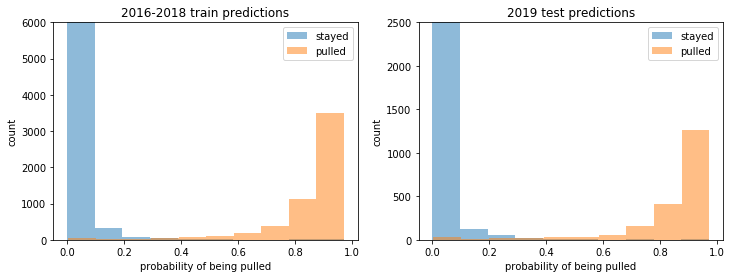

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(test_df["last_batter"], test_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     71190
         1.0       0.98      0.97      0.97      2034

    accuracy                           1.00     73224
   macro avg       0.99      0.98      0.99     73224
weighted avg       1.00      1.00      1.00     73224

mean plate appearance diff: 0.03982
mean target diff: 0.00358


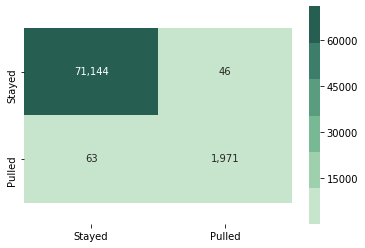

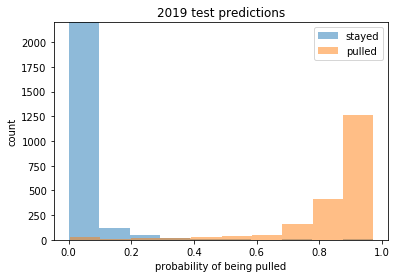

In [23]:
print_all_metrics(test_df["last_batter"], test_df["pred"], thresh=0.3)

## Log loss LSTM

In [24]:
# loading up saved model
load_model(drsa, f"../models/07-15-20_LSTM_2016_2017_2018_2019_loss_0.3965.pth")
drsa.eval()

# organizing test preds in df
test_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_test, y_test in test_dl:
    pred = drsa(X_test).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
test_df = pd.DataFrame(np.hstack([test_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

(array([3.397e+03, 2.980e+02, 2.170e+02, 3.480e+02, 8.280e+02, 3.600e+02,
        4.400e+01, 4.200e+01, 4.000e+00, 1.000e+00]),
 array([0.00038858, 0.00038887, 0.00038916, 0.00038944, 0.00038973,
        0.00039002, 0.00039031, 0.00039059, 0.00039088, 0.00039117,
        0.00039146]),
 <a list of 10 Patch objects>)

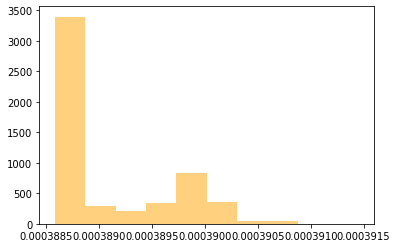

In [25]:
stayed_preds = train_df.loc[(train_df["last_batter"]==0), "pred"]
pulled_preds = train_df.loc[(train_df["last_batter"]==1), "pred"]

# plt.hist(stayed_preds, alpha=0.5, label="stayed")
plt.hist(pulled_preds, alpha=0.5, label="pulled", color="orange")
# plt.ylim(0, 300)

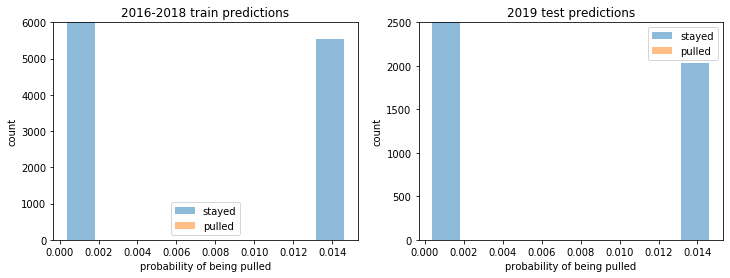

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(test_df["last_batter"], test_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     71190
         1.0       0.00      0.00      0.00      2034

    accuracy                           0.97     73224
   macro avg       0.49      0.50      0.49     73224
weighted avg       0.95      0.97      0.96     73224

mean plate appearance diff: 35.0
mean target diff: 0.02698


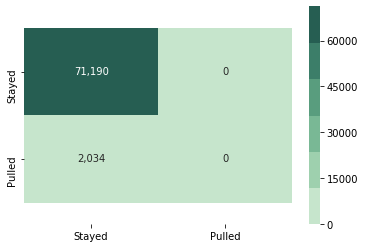

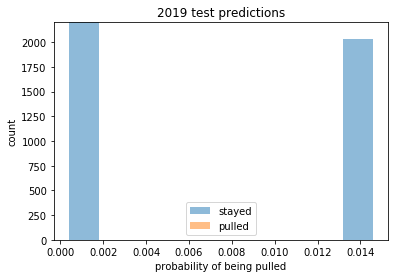

In [27]:
print_all_metrics(test_df["last_batter"], test_df["pred"], thresh=0.5)